In [1]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

startDate = '20200323'
endDate = '20200401'

readPath = r'\\192.168.10.30\Kevin_zhenyu\orderLog\equityTradeLogs'
dataPathLs = np.array(glob.glob(os.path.join(readPath, 'speedCompare***.csv')))
dateLs = np.array([os.path.basename(i).split('_')[1].split('.')[0] for i in dataPathLs])
dataPathLs = dataPathLs[(dateLs >= startDate) & (dateLs <= endDate)]
rawOrderLog = []
for thisDate, thisPath in zip(dateLs, dataPathLs):
    data = pd.read_csv(thisPath)
    data = data.rename(columns={'mdClockAtArrival': 'caamd'})
    rawOrderLog += [data]
rawOrderLog = pd.concat(rawOrderLog, sort=False)
for col in ['clockAtArrival', 'caamd', 'secid', 'updateType', 'vai', 'absFilledThisUpdate', 'orderDirection', 'absOrderSize',
            'absOrderSizeCumFilled', 'date', 'accCode', 'mse']:
    rawOrderLog[col] = rawOrderLog[col].astype('int64')   
rawOrderLog = rawOrderLog.sort_values(by=['date', 'secid', 'vai', 'accCode', 'clockAtArrival']).reset_index(drop=True)

targetStock = rawOrderLog['secid'].unique()
targetStock = np.array([int(str(i)[1:]) for i in targetStock])
targetStockSZ = sorted(targetStock[targetStock < 600000])
targetStockSH = sorted(targetStock[targetStock >= 600000])

rawOrderLog['clock'] = rawOrderLog['clockAtArrival'].apply(lambda x: datetime.datetime.fromtimestamp(x/1e6))
rawOrderLog['broker'] = rawOrderLog['accCode'] // 100
rawOrderLog['colo_broker'] = rawOrderLog['colo'].str[:2] + '_' + rawOrderLog['broker'].astype('str')
rawOrderLog['order'] = rawOrderLog.groupby(['date', 'accCode', 'secid', 'vai']).grouper.group_info[0]
rawOrderLog['group'] = rawOrderLog.groupby(['date', 'secid', 'vai']).grouper.group_info[0]
rawOrderLog['startClock'] = rawOrderLog.groupby(['order'])['clockAtArrival'].transform('first')
rawOrderLog['duration'] = rawOrderLog['clockAtArrival'] - rawOrderLog['startClock']
rawOrderLog['orderPrice'] = rawOrderLog['orderPrice'].apply(lambda x: round(x, 2))
rawOrderLog['tradePrice'] = rawOrderLog['tradePrice'].apply(lambda x: round(x, 2))
orderLog = rawOrderLog.copy()

### make sure no order has shares > 80w or notional > 800w
orderLog['orderNtl'] = orderLog['absOrderSize'] * orderLog['orderPrice']
# assert(orderLog[orderLog['absOrderSize'] > 800000].shape[0] == 0)
# assert(orderLog[orderLog['orderNtl'] > 8000000].shape[0] == 0)
if orderLog[orderLog['absOrderSize'] > 800000].shape[0] > 0:
    print('some order quantity are > 80w')
    display(orderLog[orderLog['absOrderSize'] > 800000][['date', 'accCode', 'secid', 'vai', 'absOrderSize', 'orderPrice',
                                                         'orderNtl', 'orderDirection', 'clock', 'order']])
            
if orderLog[orderLog['orderNtl'] > 8000000].shape[0] > 0:
    print('some order ntl are > 800w')
    display(orderLog[orderLog['orderNtl'] > 8000000][['date', 'accCode', 'secid', 'vai', 'absOrderSize', 'orderPrice',
                                                      'orderNtl', 'orderDirection', 'clock', 'order', "updateType", 
                                                      "tradePrice", "absOrderSizeCumFilled", "absFilledThisUpdate"]])

### make sure same direction in same colo_broker
orderLog['directNum'] = orderLog.groupby(['date', 'secid', 'vai'])['orderDirection'].transform('nunique')
if len(orderLog[orderLog['directNum'] != 1]) > 0:
    print('opposite direction for same date, same secid, same vai')
    display(orderLog[orderLog['directNum'] != 1][['date', 'accCode', 'secid', 'vai', 'orderDirection']])
    orderLog = orderLog[orderLog['directNum'] == 1]

assert((orderLog.groupby(['date', 'secid', 'vai'])['orderDirection'].nunique() == 1).all() == True)

## make sure each account, secid, vai only has one insertion
a = orderLog[orderLog['updateType'] == 0].groupby(['date', 'accCode', 'secid', 'vai', 'order'])['clockAtArrival'].count()
if len(a[a > 1]) > 0:
    print('more than one insertion at same time')
    a = a[a>1].reset_index()
    display(a)
    orderLog = orderLog[~(orderLog['order'].isin(a['order'].unique()))]

orderLog['isMsg'] = np.where(orderLog['updateType'] == 0, 
                             np.where(orderLog['mse'] == 100, 1, 0), np.nan)
orderLog['isMsg'] = orderLog.groupby(['order'])['isMsg'].ffill()

placeSZE = orderLog[(orderLog['secid'] >= 2000000) & (orderLog['updateType'] == 0)]
print('%.2f%% SZE orders triggered by msg data'%(placeSZE[placeSZE['isMsg'] == 1].shape[0]/placeSZE.shape[0]*100))

### make sure there is no unexpected updateType 
def getTuple(x):
    return tuple(i for i in x)

checkLog = orderLog[~((orderLog['updateType'] == 4) & (orderLog.groupby(['order'])['updateType'].shift(-1) == 4))]
checkLog = checkLog.groupby(['order'])['updateType'].apply(lambda x: getTuple(x)).reset_index()
checkLog['status'] = np.where(checkLog['updateType'].isin([(0, 2, 4), (0, 2, 1, 4), (0, 2, 1, 2, 4), (0, 2, 4, 1, 4), (0, 4), (0, 4, 1, 4)]), 0,
                     np.where(checkLog['updateType'].isin([(0, 2, 4, 1, 3), (0, 2, 4, 1, 4, 3), (0, 2, 1, 4, 3), (0, 4, 1, 3)]), 1,
                     np.where(checkLog['updateType'] == (0, 2, 1, 3), 2,
                     np.where(checkLog['updateType'].isin([(0, 3)]), 3,
                     np.where(checkLog['updateType'].isin([(0, ), (0, 2), (0, 2, 1)]), 4, 5)))))

display(checkLog[checkLog['status'] == 5])
orderLog = pd.merge(orderLog, checkLog[['order', 'status']], how='left', on=['order'], validate='many_to_one')
orderLog = orderLog[orderLog['status'].isin([0, 1, 2])].reset_index(drop=True)

### check status==0 got all traded
a = orderLog[orderLog['status'] == 0]
a = a.groupby(['order'])[['absOrderSizeCumFilled', 'absOrderSize']].max().reset_index()
a.columns = ['order', 'filled', 'total']
print('in total trade, any fill != total cases')
display(a[a['filled'] != a['total']])
if a[a['filled'] != a['total']].shape[0] > 0:
    removeOrderLs = a[a['filled'] != a['total']]['order'].unique()
    orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]
    
### check status==1 got partial traded
a = orderLog[orderLog['status'] == 1]
a = a.groupby(['order'])[['absOrderSizeCumFilled', 'absOrderSize']].max().reset_index()
a.columns = ['order', 'filled', 'total']
print('in partial trade, any fill >= total or fill is 0 cases for updateType 4')
display(a[(a['filled'] >= a['total']) | (a['filled'] == 0)])
if a[(a['filled'] >= a['total']) | (a['filled'] == 0)].shape[0] > 0:
    removeOrderLs = a[(a['filled'] >= a['total']) | (a['filled'] == 0)]['order'].unique()
    orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]
    
### check if any cancellation within 1 sec
a = orderLog[(orderLog['updateType'] == 1) & (orderLog['duration'] < 1e6)]
print('any cancellation within 1 sec')
display(a)
if a.shape[0] > 0:
    removeOrderLs = a['order'].unique()
    orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]

orderLog = orderLog.sort_values(by=['date', 'secid', 'vai', 'accCode', 'clockAtArrival']).reset_index(drop=True)

orderLog['exchange'] = np.where(orderLog['secid'] >= 2000000, 'SZE', 'SSE')
orderLog['orderNtl'] = orderLog['orderPrice'] * orderLog['absOrderSize']
orderLog['tradeNtl'] = np.where(orderLog['updateType'] == 4, orderLog['tradePrice']*orderLog['absFilledThisUpdate'], 0)


C:\Users\win\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


some order ntl are > 800w


,date,accCode,secid,vai,absOrderSize,orderPrice,orderNtl,orderDirection,clock,order,updateType,tradePrice,absOrderSizeCumFilled,absFilledThisUpdate
59395,20200323,9765,2002714,862194,70800,113.00,8000400.0,1,2020-03-23 09:30:39.678464,17361,0,-1.00,0,0
59396,20200323,9765,2002714,862194,70800,113.00,8000400.0,1,2020-03-23 09:30:39.682183,17361,2,113.00,0,0
59397,20200323,9765,2002714,862194,70800,113.00,8000400.0,1,2020-03-23 09:30:39.682237,17361,4,113.00,100,100
59398,20200323,9765,2002714,862194,70800,113.00,8000400.0,1,2020-03-23 09:30:39.682298,17361,4,113.00,70800,70700
467257,20200330,5273,1600739,10911017,443200,18.06,8004192.0,1,2020-03-30 10:50:35.410013,94163,0,-1.00,0,0
467258,20200330,5273,1600739,10911017,443200,18.06,8004192.0,1,2020-03-30 10:50:35.558491,94163,2,-1.00,0,0
467259,20200330,5273,1600739,10911017,443200,18.06,8004192.0,1,2020-03-30 10:50:35.731072,94163,4,18.06,206277,206277
467260,20200330,5273,1600739,10911017,443200,18.06,8004192.0,1,2020-03-30 10:50:35.731612,94163,4,18.06,213277,7000
467261,20200330,5273,1600739,10911017,443200,18.06,8004192.0,1,2020-03-30 10:50:35.732155,94163,4,18.06,443200,229923


more than one insertion at same time


,date,accCode,secid,vai,order,clockAtArrival
0,20200323,9461,2002311,55468,11215,2
1,20200324,9454,2300243,6600,28988,2
2,20200324,9741,1603009,4115753,33087,2
3,20200325,6272,1600754,2431912,42132,2
4,20200325,8865,2002756,175500,43942,2
5,20200325,8865,2300788,29300,44152,2
6,20200325,9756,2300478,45300,54598,2
7,20200326,5269,1603368,669608,57456,2
8,20200326,5269,1603587,203700,57499,2
9,20200326,9208,2300759,39800,64215,2


96.20% SZE orders triggered by msg data


,order,updateType,status
2818,2818,"(0, 4, 1, 4, 3)",5
4807,4807,"(0, 4, 2, 4, 1, 3)",5
5241,5241,"(0, 4, 2, 4)",5
5273,5273,"(0, 4, 2, 4)",5
5627,5627,"(0, 4, 2, 4)",5
5736,5736,"(0, 4, 2, 4)",5
12689,12690,"(0, 4, 2, 4)",5
23968,23969,"(0, 4, 2, 1, 3)",5
24148,24149,"(0, 4, 2, 4)",5
36626,36629,"(0, 4, 2, 4)",5


in total trade, any fill != total cases


,order,filled,total
34,38,17600,33400
12902,16614,1300,4300
17405,22464,100,200
29291,37610,4300,13800
30539,39133,400,500
53418,68494,300,3700
53444,68528,17000,38600
56070,71777,1000,1900
72925,93614,1600,2500
77607,100072,1200,2500


in partial trade, any fill >= total or fill is 0 cases for updateType 4


,order,filled,total


any cancellation within 1 sec


,clockAtArrival,caamd,secid,updateType,vai,ars,absFilledThisUpdate,orderDirection,absOrderSize,absOrderSizeCumFilled,...,broker,colo_broker,order,group,startClock,duration,orderNtl,directNum,isMsg,status


### Read data day by day

In [23]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

date = '20200325'

readPath = r'\\192.168.10.30\Kevin_zhenyu\rawData\***'
dataPathLs = np.array(glob.glob(readPath))
serverLs = np.array([os.path.basename(i).split('_')[3] for i in dataPathLs])
dateLs = np.array([os.path.basename(i).split('_')[1] for i in dataPathLs])
dataPathLs = dataPathLs[(dateLs == date) & (serverLs == '92')]
# path1 = np.array(glob.glob(os.path.join(dataPathLs[0], "mdLog_SZ_***")))
path2 = np.array(glob.glob(os.path.join(dataPathLs[0], "mdLog_SH_***")))
# SZ = pd.read_csv(path1[0], encoding="utf-8").loc[:, ["clockAtArrival", "sequenceNo", "source", "StockID",
#                                               "exchange", "time", "cum_volume", "cum_amount", "close",
#                                               "bid1p", "bid2p", "bid3p", "bid4p", "bid5p", "bid1q",
#                                               "bid2q", "bid3q", "bid4q", "bid5q", "ask1p", "ask2p",
#                                               "ask3p", "ask4p", "ask5p", "ask1q", "ask2q", "ask3q",
#                                               "ask4q", "ask5q", "openPrice"]]
SH = pd.read_csv(path2[0], encoding="utf-8").loc[:, ["clockAtArrival", "sequenceNo", "source", "StockID",
                                              "exchange", "time", "cum_volume", "cum_amount", "close",
                                              "bid1p", "bid2p", "bid3p", "bid4p", "bid5p", "bid1q",
                                              "bid2q", "bid3q", "bid4q", "bid5q", "ask1p", "ask2p",
                                              "ask3p", "ask4p", "ask5p", "ask1q", "ask2q", "ask3q",
                                              "ask4q", "ask5q", "openPrice"]]
# SZ["StockID"] = SZ["StockID"] + 2000000

readPath = r'\\192.168.10.30\Kevin_zhenyu\mbd\***'
dataPathLs = np.array(glob.glob(readPath))
dateLs = np.array([os.path.basename(i) for i in dataPathLs])
dataPathLs = dataPathLs[dateLs == date]
path = glob.glob(os.path.join(dataPathLs[0], "Tick_SZE***"))
MBD = pd.DataFrame()
display(path)
for i in path:
    F1 = open(i, 'rb')
    df1 = pickle.load(F1)
    MBD = pd.concat([MBD, df1])
MBD = MBD.rename(columns={"ID": "StockID"})
MBD = MBD.loc[:, ["clockAtArrival", "sequenceNo", "source", "StockID",
            "time", "cum_volume", "cum_amount", "close", "bid1p",
            "bid2p", "bid3p", "bid4p", "bid5p", "bid1q", "bid2q", 
            "bid3q", "bid4q", "bid5q", "ask1p", "ask2p", "ask3p",
            "ask4p", "ask5p", "ask1q", "ask2q", "ask3q", "ask4q",
            "ask5q", "openPrice"]]
MBD["exchange"] = "SZ"

['\\\\192.168.10.30\\Kevin_zhenyu\\mbd\\20200325\\Tick_SZE1.pkl',
 '\\\\192.168.10.30\\Kevin_zhenyu\\mbd\\20200325\\Tick_SZE2.pkl']

### SSE isMsg == 1

In [60]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

date = '20200325'

readPath = r'\\192.168.10.30\Kevin_zhenyu\rawData\***'
dataPathLs = np.array(glob.glob(readPath))
serverLs = np.array([os.path.basename(i).split('_')[3] for i in dataPathLs])
dateLs = np.array([os.path.basename(i).split('_')[1] for i in dataPathLs])
dataPathLs = dataPathLs[(dateLs == date) & (serverLs == '92')]
path2 = np.array(glob.glob(os.path.join(dataPathLs[0], "mdLog_SH_***")))

SH = pd.read_csv(path2[0], encoding="utf-8").loc[:, ["clockAtArrival", "sequenceNo", "source", "StockID",
                                              "exchange", "time", "cum_volume", "cum_amount", "close",
                                              "bid1p", "bid2p", "bid3p", "bid4p", "bid5p", "bid1q",
                                              "bid2q", "bid3q", "bid4q", "bid5q", "ask1p", "ask2p",
                                              "ask3p", "ask4p", "ask5p", "ask1q", "ask2q", "ask3q",
                                              "ask4q", "ask5q", "openPrice"]]
SH["cum_max"] = SH.groupby(['StockID', 'sequenceNo'])['cum_volume'].cummax()
display(len(SH))
SH = SH[SH["cum_volume"] == SH["cum_max"]].sort_values(by=["StockID", "sequenceNo"]).reset_index(drop=True)
display(len(SH))

SH = SH.sort_values(by=["StockID", "sequenceNo"])
print(SH.groupby("StockID")["cum_volume"].nunique().sum())
SH = SH.drop_duplicates(subset=columns, keep="first").reset_index(drop=True)
print(SH.groupby("StockID")["cum_volume"].nunique().sum())
SH = SH.sort_values(by=["StockID", "sequenceNo"])
SH['b1p_diff'] = SH.groupby("StockID")["bid1p"].shift(1)
SH['b1p_diff'] = SH["bid1p"]- SH["b1p_diff"]
SH["a1p_diff"] = SH.groupby("StockID")["ask1p"].shift(1)
SH["a1p_diff"] = SH["ask1p"]- SH["a1p_diff"]
SH["different"] = np.where((SH["b1p_diff"]!=0)|(SH["a1p_diff"]!=0), True, False)
SH["count"] = SH.groupby(["StockID", "sequenceNo"])["cum_volume"].transform("count")
SH = SH[SH["count"] == 1]
SH["triggered_reason"] = np.where(SH["different"] == True, "NBBO price change", "other reason")
print(SH.groupby("StockID")["cum_volume"].nunique().sum())
orderLog["time"] = orderLog["clock"].apply(lambda x: int(x.strftime('%H%M%S')))

12917575

12917575

4249390
4249390
4249390


In [61]:
acclist = orderLog[(orderLog["exchange"] == "SSE") & (orderLog["isMsg"] == 1)& (orderLog["date"] == int(date))]["accCode"].unique()
display(acclist)
test3 = orderLog[(orderLog["exchange"] == "SSE") & (orderLog["updateType"] == 0) & (orderLog["time"] >= 94500)
                & (orderLog["date"] == int(date)) & (orderLog["accCode"].isin(acclist))].reset_index(drop=True)
SH["secid"] = SH["StockID"] + 1000000
re = pd.merge(test3, SH.groupby(["secid", "cum_volume"])["triggered_reason"].first(), left_on=["secid", "vai"], 
              right_on=["secid", "cum_volume"], how="left")
re["triggered_reason"] = np.where(re["isMsg"] == 1, "other reason", re["triggered_reason"])
display(len(test3))
n1 = len(re)
display(len(re))
display(len(re[re["triggered_reason"].isnull()]))
re = re.dropna(subset=["triggered_reason"])
n2 = len(re)
display(len(re))
re["dropped_orders"] = n1 - n2
kk3 = re.groupby(["exchange", "dropped_orders", "triggered_reason"])["secid"].count().reset_index()
kk3["date"] = date
kk3 = kk3.rename(columns={"secid": "count"})
kk3["sum"] = kk3.groupby(["date", "exchange"])["count"].transform("sum")
kk3["perc"] = kk3["count"] / kk3["sum"]
kk3['perc'] = kk3['perc'].apply(lambda x: '%.1f%%'%(100*x))
kk3

array([9666, 5271, 9441, 5868, 9248, 8854], dtype=int64)

664

664

7

657

,exchange,dropped_orders,triggered_reason,count,date,sum,perc
0,SSE,7,NBBO price change,391,20200325,657,59.5%
1,SSE,7,other reason,266,20200325,657,40.5%


In [62]:
fr = pd.concat([kk3, fr])
from IPython.display import display, HTML
HTML(fr.groupby(["date", "exchange","dropped_orders", "triggered_reason"])["count","perc"].first().to_html())
HTML(pd.merge(fr[fr["triggered_reason"] == "NBBO price change"], fr[fr["triggered_reason"] == "other reason"], on=["date", "exchange", "dropped_orders"])\
[["date", "exchange", "dropped_orders","triggered_reason_x", "perc_x", "triggered_reason_y", "perc_y"]].groupby(["date", "exchange", "dropped_orders"])["triggered_reason_x", "perc_x", "triggered_reason_y", "perc_y"].first().to_html())

,,,triggered_reason_x,perc_x,triggered_reason_y,perc_y
date,exchange,dropped_orders,,,,
20200323,SSE,2,NBBO price change,68.1%,other reason,31.9%
20200324,SSE,6,NBBO price change,65.7%,other reason,34.3%
20200325,SSE,7,NBBO price change,59.5%,other reason,40.5%


In [76]:
fr = fr.iloc[:, :-1]
fr

,exchange,dropped_orders,triggered_reason,count,date,sum,perc
0,SSE,7,NBBO price change,391,20200325,657,59.5%
1,SSE,7,other reason,266,20200325,657,40.5%
2,SSE,6,NBBO price change,513,20200324,781,65.7%
3,SSE,6,other reason,268,20200324,781,34.3%
4,SSE,2,NBBO price change,250,20200323,367,68.1%
5,SSE,2,other reason,117,20200323,367,31.9%


In [79]:
test = pd.DataFrame()
for date in [20200323, 20200324, 20200325]:
    acclist = orderLog[(orderLog["exchange"] == "SSE") & (orderLog["isMsg"] == 1)& (orderLog["date"] == int(date))]["accCode"].unique()
    df = orderLog[(orderLog["exchange"] == "SSE") & (orderLog["updateType"] == 0) & (orderLog["time"] >= 94500)
                & (orderLog["date"] == int(date)) & (orderLog["accCode"].isin(acclist))].reset_index(drop=True)
    test = pd.concat([test, df])
t1 = test.groupby(["date", "isMsg"])["exchange"].count().reset_index()
t1 = t1.rename(columns={"exchange": "percentile"})
t1["percentile"] = t1["percentile"] / t1.groupby("date")["percentile"].transform("sum")
t1['percentile'] = t1['percentile'].apply(lambda x: '%.1f%%'%(100*x))
t1 = t1[t1["isMsg"] == 1]
t1
fr["date"] = fr["date"].astype(int)
fr = pd.merge(fr, t1[["date", "percentile"]], on="date")
HTML(pd.merge(fr[fr["triggered_reason"] == "NBBO price change"], fr[fr["triggered_reason"] == "other reason"], on=["date", "exchange", "dropped_orders", "percentile"])\
[["date", "exchange", "percentile", "dropped_orders","triggered_reason_x", "perc_x", "triggered_reason_y", "perc_y"]].groupby(["date", "exchange", "percentile", "dropped_orders"])["triggered_reason_x", "perc_x", "triggered_reason_y", "perc_y"].first().to_html())

,,,,triggered_reason_x,perc_x,triggered_reason_y,perc_y
date,exchange,percentile,dropped_orders,,,,
20200323,SSE,22.2%,2,NBBO price change,68.1%,other reason,31.9%
20200324,SSE,22.5%,6,NBBO price change,65.7%,other reason,34.3%
20200325,SSE,30.1%,7,NBBO price change,59.5%,other reason,40.5%


### SZE & SSE data prepare

In [24]:
SH["cum_max"] = SH.groupby(['StockID', 'sequenceNo'])['cum_volume'].cummax()
display(len(SH))
SH = SH[SH["cum_volume"] == SH["cum_max"]].sort_values(by=["StockID", "sequenceNo"]).reset_index(drop=True)
display(len(SH))

MBD = MBD.sort_values(by=["StockID", "sequenceNo"])
columns = ["StockID", "cum_volume", "bid1p","bid2p", "bid3p", "bid4p", "bid5p", "bid1q", "bid2q", 
           "bid3q", "bid4q", "bid5q", "ask1p", "ask2p", "ask3p","ask4p", "ask5p", 
           "ask1q", "ask2q", "ask3q", "ask4q","ask5q"]
print(MBD[MBD["source"] == 100].groupby("StockID")["cum_volume"].nunique().sum())
MBD = MBD.drop_duplicates(subset=columns, keep="first").reset_index(drop=True)
print(MBD[MBD["source"] == 100].groupby("StockID")["cum_volume"].nunique().sum())
MBD = MBD.sort_values(by=["StockID", "sequenceNo"])
MBD['b1p_diff'] = MBD.groupby("StockID")["bid1p"].shift(1)
MBD['b1p_diff'] = MBD["bid1p"]- MBD["b1p_diff"]
MBD["a1p_diff"] = MBD.groupby("StockID")["ask1p"].shift(1)
MBD["a1p_diff"] = MBD["ask1p"]- MBD["a1p_diff"]
MBD["different"] = np.where((MBD["b1p_diff"]!=0)|(MBD["a1p_diff"]!=0), True, False)

SZ = MBD[MBD["source"].isin([3, 4])]
MBD = MBD[MBD["source"] == 100]
SZ["count"] = SZ.groupby(["StockID", "sequenceNo"])["cum_volume"].transform("count")
SZ = SZ[SZ["count"] == 1]
SZ["triggered_reason"] = np.where(SZ["different"] == True, "NBBO price change", "other reason")
MBD["count"] = MBD.groupby(["StockID", "sequenceNo"])["cum_volume"].transform("count")
MBD = MBD[MBD["count"] == 1]
MBD["triggered_reason"] = np.where(MBD["different"] == True, "NBBO price change", "other reason")
print(MBD.groupby("StockID")["cum_volume"].nunique().sum())


SH = SH.sort_values(by=["StockID", "sequenceNo"])
print(SH.groupby("StockID")["cum_volume"].nunique().sum())
SH = SH.drop_duplicates(subset=columns, keep="first").reset_index(drop=True)
print(SH.groupby("StockID")["cum_volume"].nunique().sum())
SH = SH.sort_values(by=["StockID", "sequenceNo"])
SH['b1p_diff'] = SH.groupby("StockID")["bid1p"].shift(1)
SH['b1p_diff'] = SH["bid1p"]- SH["b1p_diff"]
SH["a1p_diff"] = SH.groupby("StockID")["ask1p"].shift(1)
SH["a1p_diff"] = SH["ask1p"]- SH["a1p_diff"]
SH["different"] = np.where((SH["b1p_diff"]!=0)|(SH["a1p_diff"]!=0), True, False)
SH["count"] = SH.groupby(["StockID", "sequenceNo"])["cum_volume"].transform("count")
SH = SH[SH["count"] == 1]
SH["triggered_reason"] = np.where(SH["different"] == True, "NBBO price change", "other reason")
print(SH.groupby("StockID")["cum_volume"].nunique().sum())

# MBD["ss"] = "MBD"
# SZ["ss"] = "snapshot"
# total = pd.concat([MBD, SZ])
# del MBD
# del SZ
# total = total.sort_values(by=["StockID", "sequenceNo"]).reset_index(drop=True)

# total["b1p_diff"] = np.nan
# total["b1p_lag2"] = total.groupby("StockID")["bid1p"].shift(2)
# total["b1p_lag1"] = total.groupby("StockID")["bid1p"].shift(1)
# total["b1p_diff"] = np.where(total.groupby("StockID")["sequenceNo"].shift(1) == total["sequenceNo"], total["b1p_lag2"], total["b1p_lag1"])
# total["b1p_diff"] = total["bid1p"]- total["b1p_diff"]
# total["a1p_diff"] = np.nan
# total["a1p_lag2"] = total.groupby("StockID")["ask1p"].shift(2)
# total["a1p_lag1"] = total.groupby("StockID")["ask1p"].shift(1)
# total["a1p_diff"] = np.where(total.groupby("StockID")["sequenceNo"].shift(1) == total["sequenceNo"], total["a1p_lag2"], total["a1p_lag1"])
# total["a1p_diff"] = total["ask1p"]- total["a1p_diff"]
# total["different"] = np.where((total["b1p_diff"]!=0)|(total["a1p_diff"]!=0), True, False)

# MBD = total[total["ss"] == "MBD"]
# SZ = total[total["ss"] == "snapshot"]
# del total
# MBD = MBD.sort_values(by=["StockID", "sequenceNo"])
# MBD["count"] = MBD.groupby(["StockID", "cum_volume"])["different"].transform("sum")
# MBD["triggered_reason"] = np.where(MBD["count"] != 0, "NBBO price change", "other reason")
# SZ = SZ.sort_values(by=["StockID", "sequenceNo"])
# SZ["count"] = SZ.groupby(["StockID", "cum_volume"])["different"].transform("sum")
# SZ["triggered_reason"] = np.where(SZ["count"] != 0, "NBBO price change", "other reason")

12917575

12917575

14623014
14622489
14622489
4249390
4249390
4249390


In [25]:
p1 = orderLog[(orderLog["exchange"] == "SZE") & (orderLog["isMsg"] == 0) & (orderLog["date"] == int(date)) & 
        (orderLog["updateType"] == 0)].groupby(["colo", "broker", "accCode"])["isMsg"].count().reset_index()
p1["perc"] = p1["isMsg"] / p1["isMsg"].sum()
p1 = p1.rename(columns={"isMsg":"count"})
p1['perc'] = p1['perc'].apply(lambda x: '%.1f%%'%(100*x))
from IPython.display import display, HTML
HTML(p1.groupby(["colo", "broker", "accCode"])["count","perc"].first().to_html())

### isMsg == 1

In [29]:
acclist = p1[p1["count"]>70]["accCode"].values
display(acclist)
test1 = orderLog[(orderLog["exchange"] == "SZE") & (orderLog["isMsg"] == 1) & (orderLog["updateType"] == 0)
                & (orderLog["date"] == int(date)) & (~orderLog["accCode"].isin(acclist))].reset_index(drop=True)
re = pd.merge(test1, MBD.groupby(["StockID", "cum_volume"])["triggered_reason"].first().reset_index(), left_on=["secid", "vai"], 
              right_on=["StockID", "cum_volume"], how="left")
display(len(test1))
n1 = len(re)
display(len(re))
display(len(re[re["triggered_reason"].isnull()]))
re = re.dropna(subset=["triggered_reason"])
n2 = len(re)
display(len(re))
re["dropped_orders"] = n1 - n2
kk1 = re.groupby(["exchange", "isMsg", "dropped_orders", "triggered_reason"])["secid"].count().reset_index()
kk1

array([8854, 9663], dtype=int64)

11208

11208

0

11208

,exchange,isMsg,dropped_orders,triggered_reason,secid
0,SZE,1.0,0,NBBO price change,6488
1,SZE,1.0,0,other reason,4720


### isMsg == 0

In [25]:
test2 = orderLog[(orderLog["exchange"] == "SZE") & (orderLog["isMsg"] == 0) & (orderLog["updateType"] == 0)
                & (orderLog["date"] == int(date))].reset_index(drop=True)
re = pd.merge(test2, SZ.groupby(["StockID", "cum_volume"])["triggered_reason"].first().reset_index(), left_on=["secid", "vai"], 
              right_on=["StockID", "cum_volume"], how="left")
display(len(test2))
n1 = len(re)
display(len(re))
display(len(re[re["triggered_reason"].isnull()]))
re = re.dropna(subset=["triggered_reason"])
n2 = len(re)
display(len(re))
re["dropped_orders"] = n1 - n2
kk2 = re.groupby(["exchange", "isMsg", "dropped_orders", "triggered_reason"])["secid"].count().reset_index()
kk2

1360

1360

1202

158

,exchange,isMsg,dropped_orders,triggered_reason,secid
0,SZE,0.0,1202,NBBO price change,130
1,SZE,0.0,1202,other reason,28


In [30]:
acclist = orderLog[(orderLog["exchange"] == "SSE") & (orderLog["isMsg"] == 1)& (orderLog["date"] == int(date))]["accCode"].unique()
display(acclist)
test3 = orderLog[(orderLog["exchange"] == "SSE") & (orderLog["isMsg"] == 0) & (orderLog["updateType"] == 0)
                & (orderLog["date"] == int(date)) & (~orderLog["accCode"].isin(acclist))].reset_index(drop=True)
SH["secid"] = SH["StockID"] + 1000000
re = pd.merge(test3, SH.groupby(["secid", "cum_volume"])["triggered_reason"].first(), left_on=["secid", "vai"], 
              right_on=["secid", "cum_volume"], how="left")
display(len(test3))
n1 = len(re)
display(len(re))
display(len(re[re["triggered_reason"].isnull()]))
re = re.dropna(subset=["triggered_reason"])
n2 = len(re)
display(len(re))
re["dropped_orders"] = n1 - n2
kk3 = re.groupby(["exchange", "isMsg", "dropped_orders", "triggered_reason"])["secid"].count().reset_index()
kk3

array([9666, 5271, 9441, 5868, 9248, 8854], dtype=int64)

6511

6511

6

6505

,exchange,isMsg,dropped_orders,triggered_reason,secid
0,SSE,0.0,6,NBBO price change,4748
1,SSE,0.0,6,other reason,1757


In [32]:
kk = pd.concat([kk1, kk3])
kk["date"] = date
kk = kk.rename(columns={"secid": "count"})
kk["sum"] = kk.groupby(["date", "exchange", "isMsg"])["count"].transform("sum")
kk["perc"] = kk["count"] / kk["sum"]
kk['perc'] = kk['perc'].apply(lambda x: '%.1f%%'%(100*x))
    
from IPython.display import display, HTML
HTML(kk.groupby(["date", "exchange", "isMsg","dropped_orders", "triggered_reason"])["count","perc"].first().to_html())

In [33]:
fr = pd.concat([kk, fr])
from IPython.display import display, HTML
HTML(fr.groupby(["date", "exchange", "isMsg","dropped_orders", "triggered_reason"])["count","perc"].first().to_html())

In [34]:
HTML(pd.merge(fr[fr["triggered_reason"] == "NBBO price change"], fr[fr["triggered_reason"] == "other reason"], on=["date", "exchange", "isMsg","dropped_orders"])\
[["date", "exchange", "isMsg","dropped_orders","triggered_reason_x", "perc_x", "triggered_reason_y", "perc_y"]].groupby(["date", "exchange", "isMsg","dropped_orders"])["triggered_reason_x", "perc_x", "triggered_reason_y", "perc_y"].first().to_html())

### SZE 20200323 snapshot order question

In [42]:
l = []
l1 = []
for i in [20200323, 20200324, 20200325, 20200326, 20200327, 20200330, 20200331, 20200401]:
    l.append(len(orderLog[(orderLog["exchange"] == "SZE") & (orderLog["isMsg"] == 0) & (orderLog["updateType"] == 0)
                & (orderLog["date"] == i)]) / len(orderLog[(orderLog["exchange"] == "SZE") & (orderLog["updateType"] == 0)
                & (orderLog["date"] == i)]))
    l1.append(orderLog[(orderLog["exchange"] == "SZE") & (orderLog["isMsg"] == 0) & (orderLog["date"] == i)]["tradeNtl"].sum()/
orderLog[(orderLog["exchange"] == "SZE") & (orderLog["date"] == i)]["tradeNtl"].sum())
df = pd.DataFrame()
df["date"] = pd.Series([20200323, 20200324, 20200325, 20200326, 20200327, 20200330, 20200331, 20200401])
df["perc"] = l
df["tradeNtl_perc"] = l1
df['perc'] = df['perc'].apply(lambda x: '%.1f%%'%(100*x))
df['tradeNtl_perc'] = df['tradeNtl_perc'].apply(lambda x: '%.1f%%'%(100*x))    
df

,date,perc,tradeNtl_perc
0,20200323,11.9%,29.7%
1,20200324,2.9%,1.5%
2,20200325,4.4%,3.7%
3,20200326,2.4%,0.9%
4,20200327,3.0%,1.6%
5,20200330,2.2%,1.2%
6,20200331,2.1%,0.6%
7,20200401,1.6%,0.5%


In [126]:
p1 = orderLog[(orderLog["exchange"] == "SZE") & (orderLog["isMsg"] == 0) & (orderLog["date"] == 20200323) & 
        (orderLog["updateType"] == 0)].groupby(["colo", "broker", "accCode"])["isMsg"].count().reset_index()
p1["perc"] = p1["isMsg"] / p1["isMsg"].sum()
p1 = p1.rename(columns={"isMsg":"count"})
p1['perc'] = p1['perc'].apply(lambda x: '%.1f%%'%(100*x))
from IPython.display import display, HTML
HTML(p1.groupby(["colo", "broker", "accCode"])["count","perc"].first().to_html())

count       440
mean     124993
std       16155
min       93003
25%      105844
50%      135045
75%      140303
max      145648
Name: clock, dtype: int32

count      340
mean     93824
std        958
min      93000
25%      93026
50%      93811
75%      93844
max      95959
Name: clock, dtype: int32

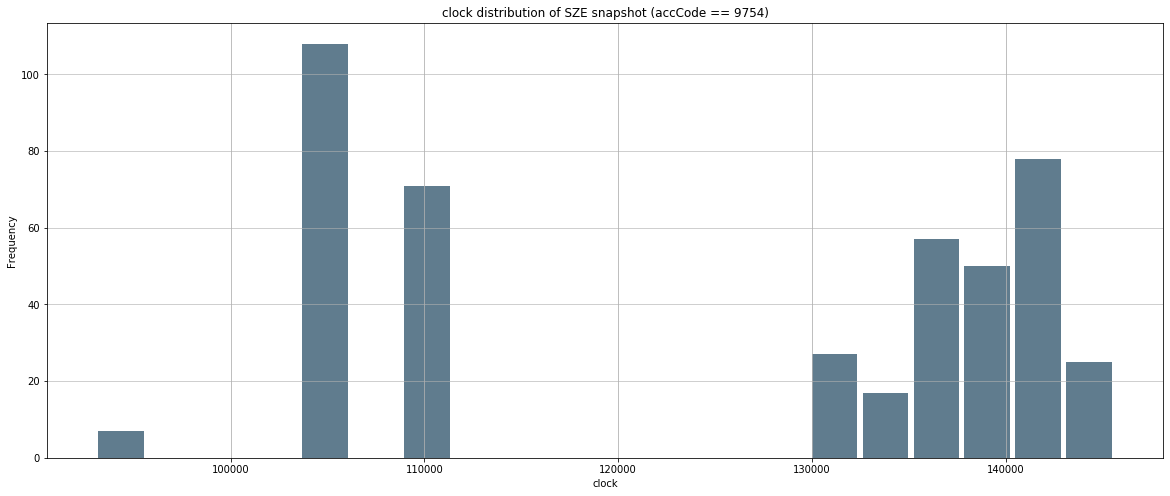

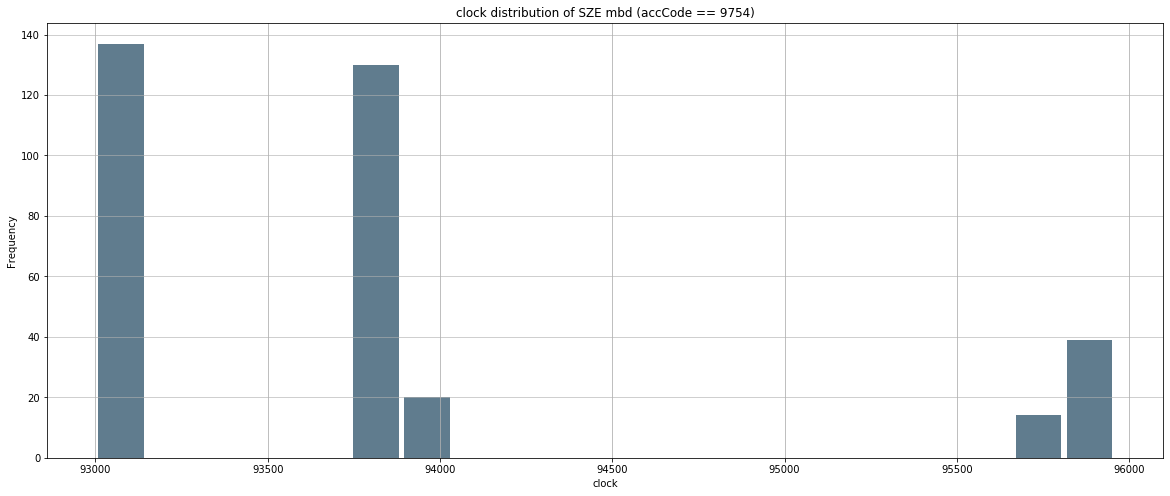

In [111]:
display(orderLog[(orderLog["exchange"] == "SZE") & (orderLog["isMsg"] == 0) & (orderLog["date"] == 20200323) & (orderLog["accCode"] == 9754) 
         & (orderLog["updateType"] == 0)]["clock"].apply(lambda x: int(x.strftime('%H%M%S'))).describe().astype(int))
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 8))
orderLog[(orderLog["exchange"] == "SZE") & (orderLog["isMsg"] == 0) & (orderLog["date"] == 20200323) & (orderLog["accCode"] == 9754) 
         & (orderLog["updateType"] == 0)]["clock"].apply(lambda x: int(x.strftime('%H%M%S'))).plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('clock distribution of SZE snapshot (accCode == 9754)')
plt.xlabel('clock')
plt.grid(axis='y', alpha=0.75)
display(orderLog[(orderLog["exchange"] == "SZE") & (orderLog["isMsg"] == 1) & (orderLog["date"] == 20200323) & (orderLog["accCode"] == 9754) 
         & (orderLog["updateType"] == 0)]["clock"].apply(lambda x: int(x.strftime('%H%M%S'))).describe().astype(int))
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 8))
orderLog[(orderLog["exchange"] == "SZE") & (orderLog["isMsg"] == 1) & (orderLog["date"] == 20200323) & (orderLog["accCode"] == 9754) 
         & (orderLog["updateType"] == 0)]["clock"].apply(lambda x: int(x.strftime('%H%M%S'))).plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('clock distribution of SZE mbd (accCode == 9754)')
plt.xlabel('clock')
plt.grid(axis='y', alpha=0.75)


count       134
mean     118145
std       15283
min       93003
25%      105460
50%      110133
75%      130306
max      145648
Name: clock, dtype: int32

count      461
mean     93066
std        187
min      93000
25%      93009
50%      93022
75%      93039
max      93955
Name: clock, dtype: int32

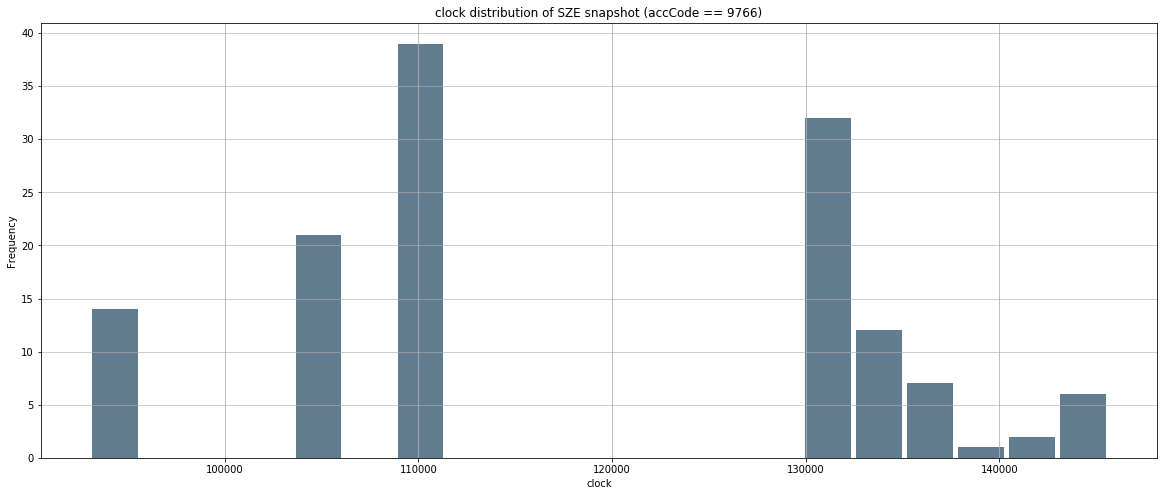

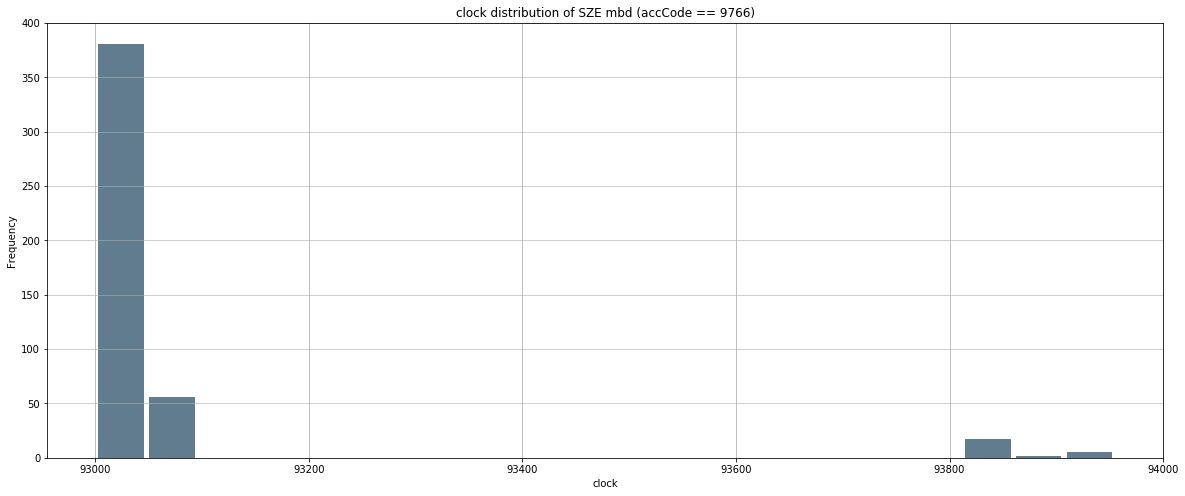

In [114]:
display(orderLog[(orderLog["exchange"] == "SZE") & (orderLog["isMsg"] == 0) & (orderLog["date"] == 20200323) & (orderLog["accCode"] == 9766) 
         & (orderLog["updateType"] == 0)]["clock"].apply(lambda x: int(x.strftime('%H%M%S'))).describe().astype(int))
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 8))
orderLog[(orderLog["exchange"] == "SZE") & (orderLog["isMsg"] == 0) & (orderLog["date"] == 20200323) & (orderLog["accCode"] == 9766) 
         & (orderLog["updateType"] == 0)]["clock"].apply(lambda x: int(x.strftime('%H%M%S'))).plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('clock distribution of SZE snapshot (accCode == 9766)')
plt.xlabel('clock')
plt.grid(axis='y', alpha=0.75)
display(orderLog[(orderLog["exchange"] == "SZE") & (orderLog["isMsg"] == 1) & (orderLog["date"] == 20200323) & (orderLog["accCode"] == 9766) 
         & (orderLog["updateType"] == 0)]["clock"].apply(lambda x: int(x.strftime('%H%M%S'))).describe().astype(int))
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 8))
orderLog[(orderLog["exchange"] == "SZE") & (orderLog["isMsg"] == 1) & (orderLog["date"] == 20200323) & (orderLog["accCode"] == 9766) 
         & (orderLog["updateType"] == 0)]["clock"].apply(lambda x: int(x.strftime('%H%M%S'))).plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('clock distribution of SZE mbd (accCode == 9766)')
plt.xlabel('clock')
plt.grid(axis='y', alpha=0.75)

count       225
mean     125942
std       17473
min       93012
25%      105615
50%      135057
75%      140827
max      145633
Name: clock, dtype: int32

count       479
mean      93321
std         742
min       93008
25%       93019
50%       93039
75%       93103
max      100000
Name: clock, dtype: int32

count       145
mean     126576
std       18062
min       93012
25%      105748
50%      135230
75%      145042
max      145654
Name: clock, dtype: int32

count      260
mean     93698
std        764
min      93008
25%      93041
50%      93824
75%      93908
max      95945
Name: clock, dtype: int32

count       187
mean     133975
std       12657
min       93012
25%      135109
50%      140233
75%      140242
max      145506
Name: clock, dtype: int32

count      193
mean     93080
std        315
min      93008
25%      93014
50%      93027
75%      93040
max      95924
Name: clock, dtype: int32

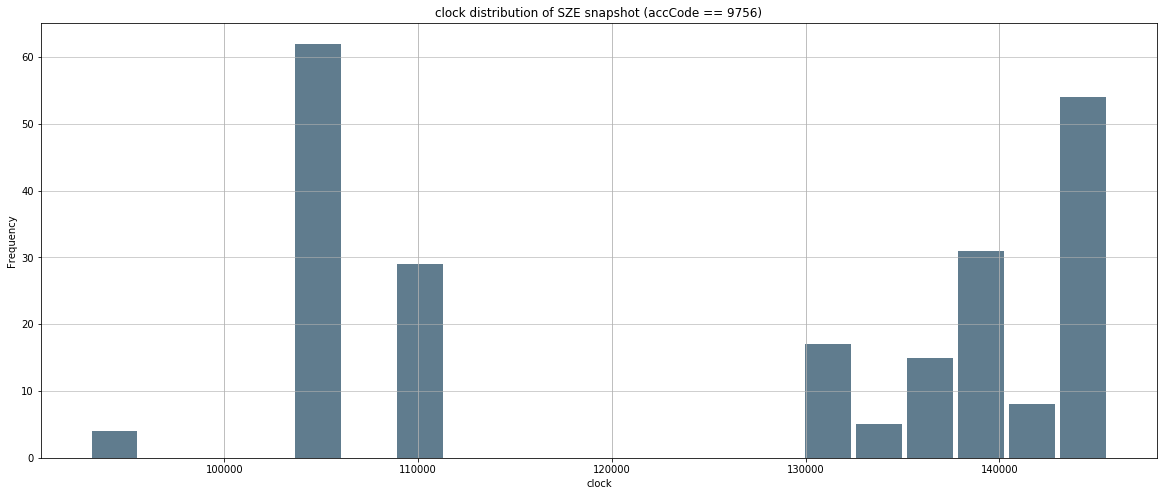

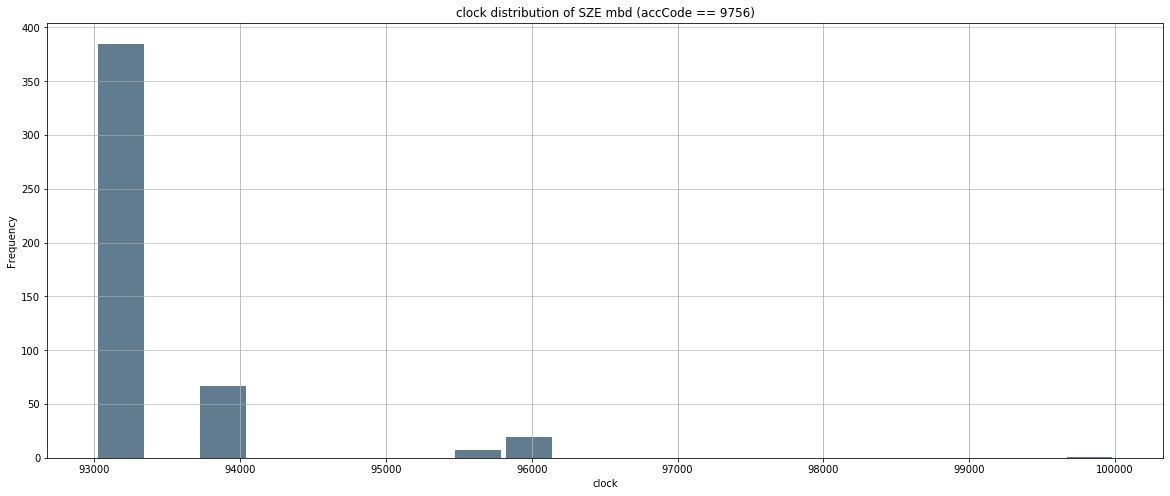

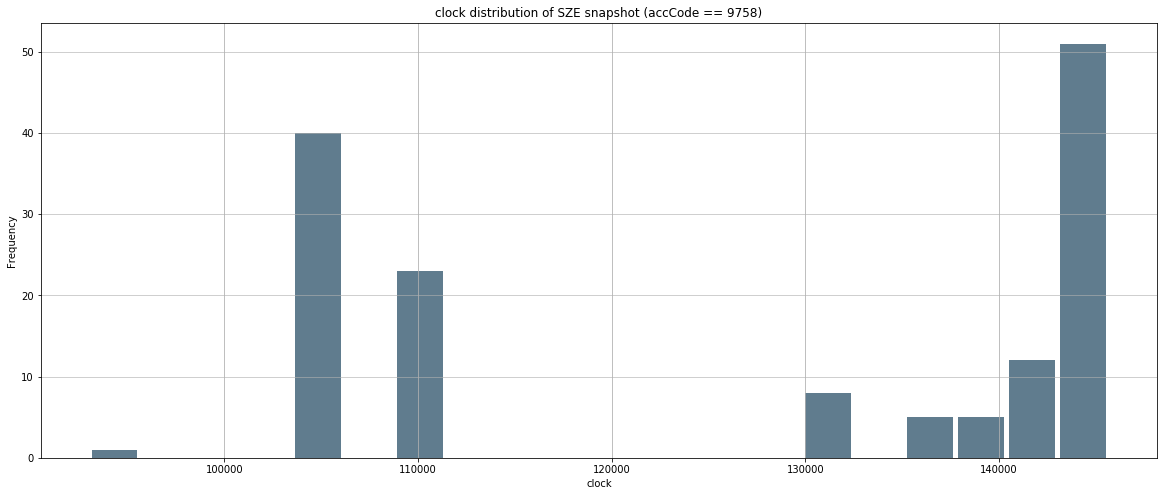

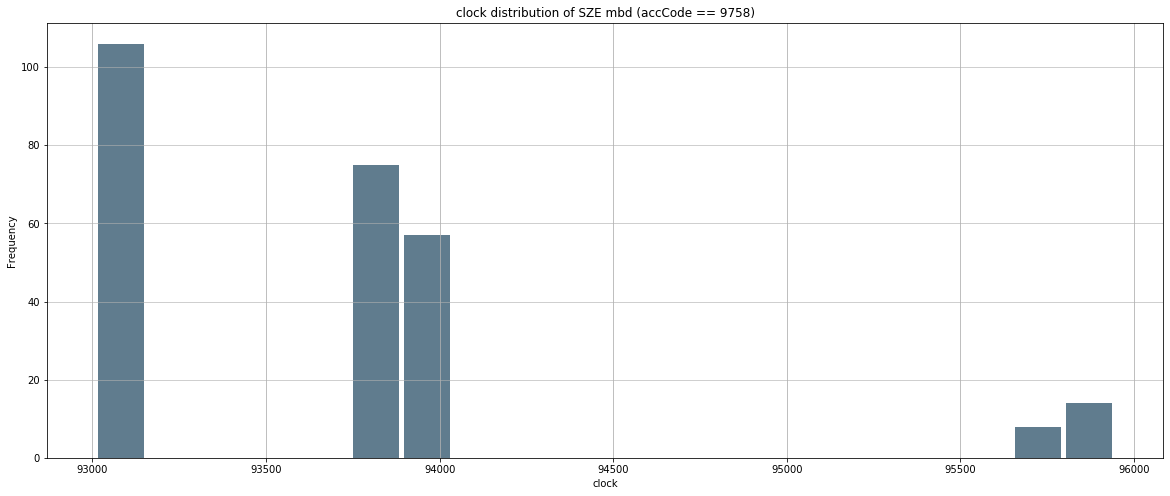

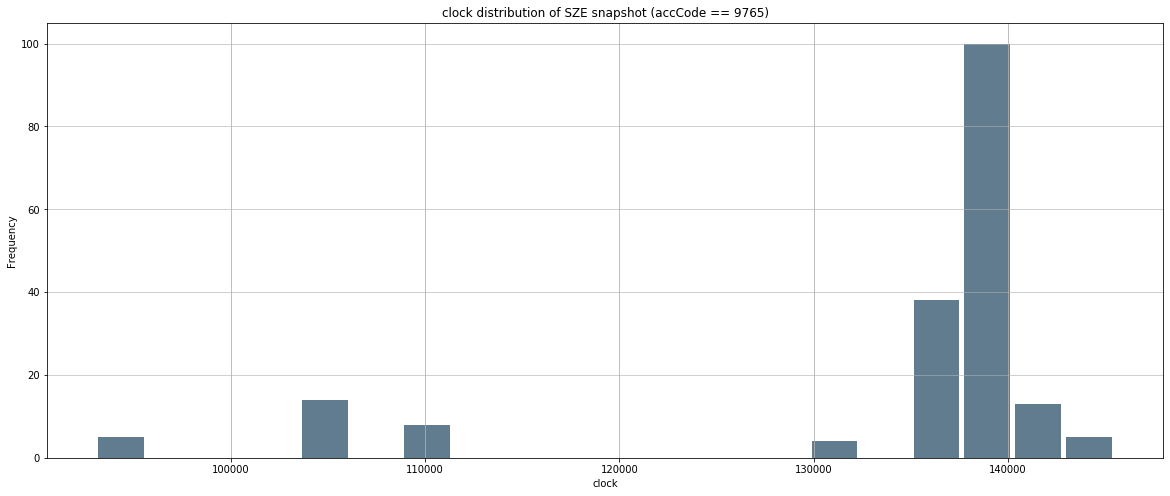

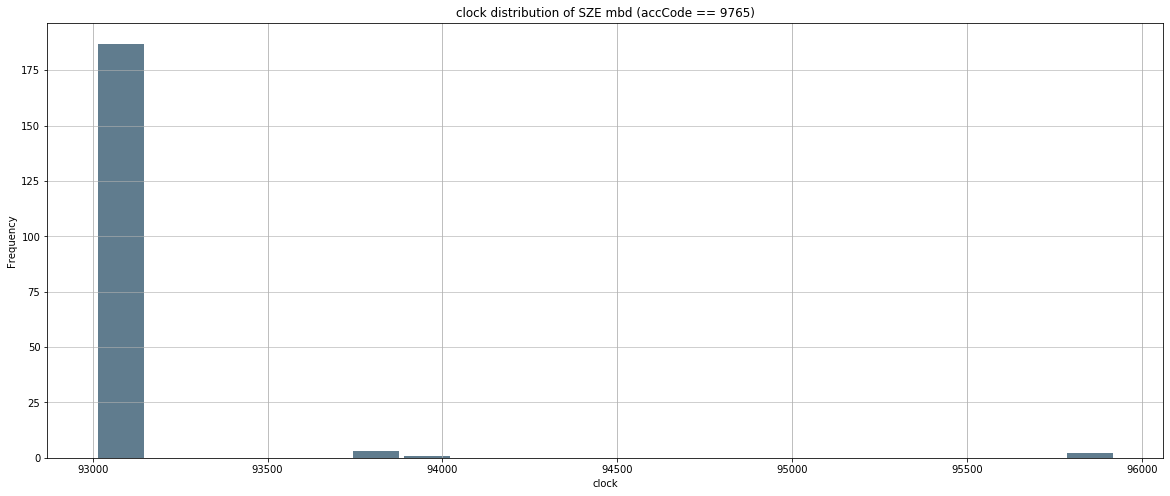

In [113]:
display(orderLog[(orderLog["exchange"] == "SZE") & (orderLog["isMsg"] == 0) & (orderLog["date"] == 20200323) & (orderLog["accCode"] == 9756) 
         & (orderLog["updateType"] == 0)]["clock"].apply(lambda x: int(x.strftime('%H%M%S'))).describe().astype(int))
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 8))
orderLog[(orderLog["exchange"] == "SZE") & (orderLog["isMsg"] == 0) & (orderLog["date"] == 20200323) & (orderLog["accCode"] == 9756) 
         & (orderLog["updateType"] == 0)]["clock"].apply(lambda x: int(x.strftime('%H%M%S'))).plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('clock distribution of SZE snapshot (accCode == 9756)')
plt.xlabel('clock')
plt.grid(axis='y', alpha=0.75)
display(orderLog[(orderLog["exchange"] == "SZE") & (orderLog["isMsg"] == 1) & (orderLog["date"] == 20200323) & (orderLog["accCode"] == 9756) 
         & (orderLog["updateType"] == 0)]["clock"].apply(lambda x: int(x.strftime('%H%M%S'))).describe().astype(int))
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 8))
orderLog[(orderLog["exchange"] == "SZE") & (orderLog["isMsg"] == 1) & (orderLog["date"] == 20200323) & (orderLog["accCode"] == 9756) 
         & (orderLog["updateType"] == 0)]["clock"].apply(lambda x: int(x.strftime('%H%M%S'))).plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('clock distribution of SZE mbd (accCode == 9756)')
plt.xlabel('clock')
plt.grid(axis='y', alpha=0.75)
display(orderLog[(orderLog["exchange"] == "SZE") & (orderLog["isMsg"] == 0) & (orderLog["date"] == 20200323) & (orderLog["accCode"] == 9758) 
         & (orderLog["updateType"] == 0)]["clock"].apply(lambda x: int(x.strftime('%H%M%S'))).describe().astype(int))
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 8))
orderLog[(orderLog["exchange"] == "SZE") & (orderLog["isMsg"] == 0) & (orderLog["date"] == 20200323) & (orderLog["accCode"] == 9758) 
         & (orderLog["updateType"] == 0)]["clock"].apply(lambda x: int(x.strftime('%H%M%S'))).plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('clock distribution of SZE snapshot (accCode == 9758)')
plt.xlabel('clock')
plt.grid(axis='y', alpha=0.75)
display(orderLog[(orderLog["exchange"] == "SZE") & (orderLog["isMsg"] == 1) & (orderLog["date"] == 20200323) & (orderLog["accCode"] == 9758) 
         & (orderLog["updateType"] == 0)]["clock"].apply(lambda x: int(x.strftime('%H%M%S'))).describe().astype(int))
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 8))
orderLog[(orderLog["exchange"] == "SZE") & (orderLog["isMsg"] == 1) & (orderLog["date"] == 20200323) & (orderLog["accCode"] == 9758) 
         & (orderLog["updateType"] == 0)]["clock"].apply(lambda x: int(x.strftime('%H%M%S'))).plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('clock distribution of SZE mbd (accCode == 9758)')
plt.xlabel('clock')
plt.grid(axis='y', alpha=0.75)
display(orderLog[(orderLog["exchange"] == "SZE") & (orderLog["isMsg"] == 0) & (orderLog["date"] == 20200323) & (orderLog["accCode"] == 9765) 
         & (orderLog["updateType"] == 0)]["clock"].apply(lambda x: int(x.strftime('%H%M%S'))).describe().astype(int))
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 8))
orderLog[(orderLog["exchange"] == "SZE") & (orderLog["isMsg"] == 0) & (orderLog["date"] == 20200323) & (orderLog["accCode"] == 9765) 
         & (orderLog["updateType"] == 0)]["clock"].apply(lambda x: int(x.strftime('%H%M%S'))).plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('clock distribution of SZE snapshot (accCode == 9765)')
plt.xlabel('clock')
plt.grid(axis='y', alpha=0.75)
display(orderLog[(orderLog["exchange"] == "SZE") & (orderLog["isMsg"] == 1) & (orderLog["date"] == 20200323) & (orderLog["accCode"] == 9765) 
         & (orderLog["updateType"] == 0)]["clock"].apply(lambda x: int(x.strftime('%H%M%S'))).describe().astype(int))
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 8))
orderLog[(orderLog["exchange"] == "SZE") & (orderLog["isMsg"] == 1) & (orderLog["date"] == 20200323) & (orderLog["accCode"] == 9765) 
         & (orderLog["updateType"] == 0)]["clock"].apply(lambda x: int(x.strftime('%H%M%S'))).plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('clock distribution of SZE mbd (accCode == 9765)')
plt.xlabel('clock')
plt.grid(axis='y', alpha=0.75)

count        72
mean     104029
std       19092
min       93000
25%       93012
50%       93077
75%      106822
max      145621
Name: clock, dtype: int32

ValueError: cannot convert float NaN to integer

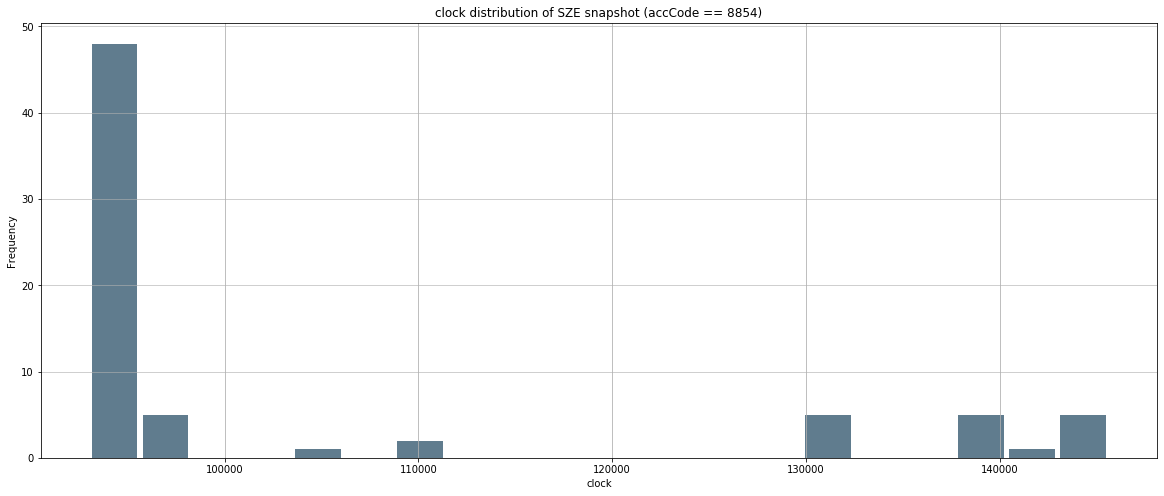

In [28]:
display(orderLog[(orderLog["exchange"] == "SZE") & (orderLog["isMsg"] == 0) & (orderLog["date"] == int(date)) & (orderLog["accCode"] == 9663) 
         & (orderLog["updateType"] == 0)]["clock"].apply(lambda x: int(x.strftime('%H%M%S'))).describe().astype(int))
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 8))
orderLog[(orderLog["exchange"] == "SZE") & (orderLog["isMsg"] == 0) & (orderLog["date"] == int(date)) & (orderLog["accCode"] == 9663) 
         & (orderLog["updateType"] == 0)]["clock"].apply(lambda x: int(x.strftime('%H%M%S'))).plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('clock distribution of SZE snapshot (accCode == 8854)')
plt.xlabel('clock')
plt.grid(axis='y', alpha=0.75)
display(orderLog[(orderLog["exchange"] == "SZE") & (orderLog["isMsg"] == 1) & (orderLog["date"] == int(date)) & (orderLog["accCode"] == 9663)
         & (orderLog["updateType"] == 0)]["clock"].apply(lambda x: int(x.strftime('%H%M%S'))).describe().astype(int))
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 8))
orderLog[(orderLog["exchange"] == "SZE") & (orderLog["isMsg"] == 1) & (orderLog["date"] == int(date)) & (orderLog["accCode"] == 9663) 
         & (orderLog["updateType"] == 0)]["clock"].apply(lambda x: int(x.strftime('%H%M%S'))).plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('clock distribution of SZE mbd (accCode == 8854)')
plt.xlabel('clock')
plt.grid(axis='y', alpha=0.75)